In [17]:
%load_ext tensorboard

In [22]:
import datetime, os

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from tensorflow.keras.callbacks import TensorBoard

In [5]:
image_size = (28, 28)

def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

for label in QuickDrawData().drawing_names:
    generate_class_images(label, max_drawings=1200, recognized=True)

loading aircraft carrier drawings
load complete
downloading airplane from https://storage.googleapis.com/quickdraw_dataset/full/binary/airplane.bin
download complete
loading airplane drawings
load complete
downloading alarm clock from https://storage.googleapis.com/quickdraw_dataset/full/binary/alarm clock.bin
download complete
loading alarm clock drawings
load complete
downloading ambulance from https://storage.googleapis.com/quickdraw_dataset/full/binary/ambulance.bin
download complete
loading ambulance drawings
load complete
downloading angel from https://storage.googleapis.com/quickdraw_dataset/full/binary/angel.bin
download complete
loading angel drawings
load complete
downloading animal migration from https://storage.googleapis.com/quickdraw_dataset/full/binary/animal migration.bin
download complete
loading animal migration drawings
load complete
downloading ant from https://storage.googleapis.com/quickdraw_dataset/full/binary/ant.bin
download complete
loading ant drawings
load c

downloading camel from https://storage.googleapis.com/quickdraw_dataset/full/binary/camel.bin
download complete
loading camel drawings
load complete
downloading camera from https://storage.googleapis.com/quickdraw_dataset/full/binary/camera.bin
download complete
loading camera drawings
load complete
downloading camouflage from https://storage.googleapis.com/quickdraw_dataset/full/binary/camouflage.bin
download complete
loading camouflage drawings
load complete
downloading campfire from https://storage.googleapis.com/quickdraw_dataset/full/binary/campfire.bin
download complete
loading campfire drawings
load complete
downloading candle from https://storage.googleapis.com/quickdraw_dataset/full/binary/candle.bin
download complete
loading candle drawings
load complete
downloading cannon from https://storage.googleapis.com/quickdraw_dataset/full/binary/cannon.bin
download complete
loading cannon drawings
load complete
downloading canoe from https://storage.googleapis.com/quickdraw_dataset/f

KeyboardInterrupt: 

In [6]:
epochs = 14
batch_size = 32
n_classes = 345

train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 448500 files belonging to 345 classes.
Using 358800 files for training.


2022-02-20 18:02:51.602948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-20 18:02:51.602979: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-20 18:02:51.602998: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lars-UM700): /proc/driver/nvidia/version does not exist
2022-02-20 18:02:51.604364: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 448500 files belonging to 345 classes.
Using 89700 files for validation.


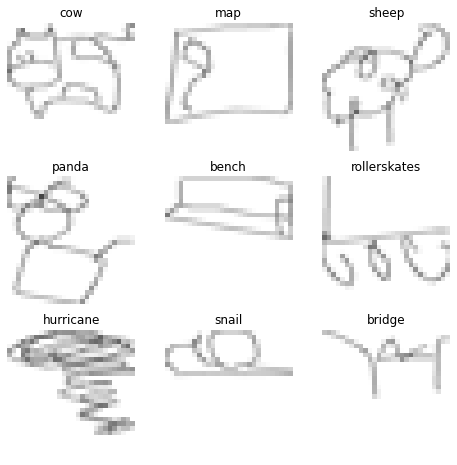

In [18]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [16]:
input_shape = (28, 28, 1)

model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         440       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 10)        730       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 10)        40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

train(train_ds, val_ds, epochs)
model.save('./models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Epoch 1/14
    3/11213 [..............................] - ETA: 10:54 - loss: 3.2134 - accuracy: 0.2604

2022-02-20 18:13:59.156759: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-20 18:13:59.156834: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-20 18:13:59.157183: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-20 18:13:59.271943: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-20 18:13:59.271980: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-20 18:13:59.309190: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-20 18:13:59.312764: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-20 18:13:59.318043: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20220220-181359/train/plugins/profile/2022_02_20_18_13_59

2022-02-20 18:13:59.320653: I tensorfl

 5900/11213 [==============>...............] - ETA: 2:43 - loss: 2.7448 - accuracy: 0.3487

In [25]:
%tensorboard --logdir logs